## Import libraries

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import os
import re
import random
import unicodedata

import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

# Constants
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
USE_CUDA = (str(DEVICE)=="cuda")
print(f"Using device: {DEVICE}")
CURR_DIR = os.path.dirname(os.path.abspath(__file__))
DATA_DIR = os.path.join(CURR_DIR, "..", "")

Using device: cuda


## Preparing dataset

In [2]:
SOS_TOKEN = 0
EOS_TOKEN = 1

class Lang :
  def __init__(self, name) -> None :
    self.name = name
    self.word2index = {}
    self.word2count = {}
    self.index2word = {0: "<SOS>", 1: "<EOS>"}
    self.n_words = 2
  def add_sentence(self, sentence) :
    for word in sentence.split(' ') :
      self.add_word(word)
  def add_word(self, word) :
    if word not in self.word2index :
      self.word2index[word] = self.n_words
      self.word2count[word] = 1
      self.index2word[self.n_words] = word
      self.n_words += 1
    else :
      self.word2count[word] += 1

In [3]:
# Turn a Unicode string into plain ASCII
def unicode_to_ascii(s) :
  return ''.join(
    c for c in unicodedata.normalize("NFD", s)
    if unicodedata.category(c) != "Mn"
  )

# Lowercase, trim, and remove non-letter characters
def normalize_string(s) :
  s = unicode_to_ascii(s.lower().strip())
  s = re.sub(r"([.!?])", r" \1", s)
  s = re.sub(r"[^a-zA-Z!?]+", r' ', s)
  return s.strip()

In [4]:
def read_langs(lang1, lang2, reverse=False) :
  print("Reading lines ..")

  # Read the file and split into lines
  lines = open(f"{lang1}-{lang2}.txt", encoding="utf-8").read().strip().split('\n')
  
  # Split every line into pairs and normalize
  pairs = [[normalize_string(s) for s in line.split('\t')] for line in lines]

  # Reverse pairs, make Lang instances
  if reverse :
    pairs = [list(reversed(pair)) for pair in pairs]
    input_lang = Lang(lang2)
    output_lang = Lang(lang1)
  else :
    input_lang = Lang(lang1)
    output_lang = Lang(lang2)
  
  return input_lang, output_lang, pairs

In [5]:
MAX_LENGTH = 10
eng_prefixes = (
  "i am ", "i m ",
  "he is ", "he s ",
  "she is", "she s ",
  "you are", "you re ",
  "we are", "we re ",
  "they are", "they re "
)

def filter_pair(pair) :
  return len(pair[0].split(' ')) < MAX_LENGTH and \
         len(pair[1].split(' ')) < MAX_LENGTH and \
         pair[1].startswith(eng_prefixes)

def filter_pairs(pairs) :
  return [pair for pair in pairs if filter_pair(pair)]

In [6]:
def prepare_data(lang1, lang2, reverse=False) :
  input_lang, output_lang, pairs = read_langs(lang1, lang2, reverse)
  print(f"Read {len(pairs)} sentence pairs")
  pairs = filter_pairs(pairs)
  print(f"Trimmed to {len(pairs)} sentence pairs")
  print("Counting words ..")
  for pair in pairs :
    input_lang.add_sentence(pair[0])
    output_lang.add_sentence(pair[1])
  print("Counted words :")
  print(input_lang.name, input_lang.n_words)
  print(output_lang.name, output_lang.n_words)
  return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepare_data("eng", "fra", True)
print(random.choice(pairs))

Reading lines ..
Read 135842 sentence pairs
Trimmed to 11423 sentence pairs
Counting words ..
Counted words :
fra 4599
eng 2990
['elle est innocente', 'she s innocent']


## Turning training data into Tensors/Variables

In [7]:
def indexes_from_sentence(lang, sentence) :
  return [lang.word2index[word] for word in sentence.split(' ')]

def variable_from_sentence(lang, sentence) :
  indexes = indexes_from_sentence(lang, sentence)
  indexes.append(EOS_TOKEN)
  var = Variable(torch.LongTensor(indexes).view(-1, 1))
  if USE_CUDA :
    var = var.cuda()
  return var

def variables_from_pair(pair) :
  input_variable = variable_from_sentence(input_lang, pair[0])
  output_variable = variable_from_sentence(output_lang, pair[1])
  return (input_variable, output_variable)

## Model definitions

### Encoder

In [8]:
class Encoder(nn.Module) :
  def __init__(self, input_size, hidden_size, n_layers=1) -> None :
    super(Encoder, self).__init__()

    self.input_size = input_size
    self.hidden_size = hidden_size
    self.n_layers = n_layers

    self.embedding = nn.Embedding(input_size, hidden_size)
    self.gru = nn.GRU(hidden_size, hidden_size, n_layers)

  def forward(self, word_inputs, hidden) :
    seq_len = len(word_inputs)
    embedded = self.embedding(word_inputs).view(seq_len, 1, -1)
    output, hidden = self.gru(embedded, hidden)
    return output, hidden
  
  def init_hidden(self) :
    hidden = Variable(torch.zeros(self.n_layers, 1, self.hidden_size))
    if USE_CUDA :
      hidden = hidden.cuda()
    return hidden

### Attention

In [40]:
class Attn(nn.Module) :
  def __init__(self, method, hidden_size) -> None :
    super(Attn, self).__init__()

    self.method = method
    self.hidden_size = hidden_size

    if self.method == "general" :
      self.attn = nn.Linear(self.hidden_size, hidden_size)
    elif self.method == "concat" :
      self.attn = nn.Linear(self.hidden_size*2, hidden_size)
      self.other = nn.Parameter(torch.FloatTensor(hidden_size))
  
  def forward(self, hidden, encoder_outputs) :
    seq_len = len(encoder_outputs)

    # Create variable to store attention energies
    attn_energies = Variable(torch.zeros(seq_len)) # B x 1 x S
    if USE_CUDA :
      attn_energies = attn_energies.cuda()
    
    # Calculate energies for each encoder output
    for i in range(seq_len) :
      attn_energies[i] = self.score(hidden.squeeze(0), encoder_outputs[i].squeeze(0))
    
    # Normalize energiees to weights in range 0 to 1, resize to 1 x 1 x seq_len
    return F.softmax(attn_energies).unsqueeze(0).unsqueeze(0)

  def score(self, hidden, encoder_output) :
    # print("hidden shape", hidden.shape, hidden)
    # print("encoder_output shape", encoder_output.shape, encoder_output)
    if self.method == "dot" :
      energy = hidden.dot(encoder_output)
    elif self.method == "general" :
      energy = self.attn(encoder_output)
      energy = hidden.dot(energy)
    elif self.method == "concat" :
      hidden = hidden.unsqueeze(0)
      encoder_output = encoder_output.unsqueeze(0)
      energy = self.attn(torch.cat((hidden, encoder_output), 1))
      energy = self.other.dot(energy.squeeze(0))
    return energy

### AttnDecoderRNN

In [26]:
class AttnDecoderRNN(nn.Module) :
  def __init__(self, attn_model, hidden_size, output_size, n_layers=1, dropout_proba=.1) -> None :
    super(AttnDecoderRNN, self).__init__()
    
    self.attn_model = attn_model
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.n_layers = n_layers
    self.dropout_proba = dropout_proba

    # Define layers
    self.embedding = nn.Embedding(output_size, hidden_size)
    self.gru = nn.GRU(hidden_size*2, hidden_size, n_layers, dropout=dropout_proba)
    self.out = nn.Linear(hidden_size*2, output_size)

    # Choose attention model
    if attn_model != "none" :
      self.attn = Attn(attn_model, hidden_size)
  
  def forward(self, word_input, last_context, last_hidden, encoder_outputs) :
    # Get the embedding of the current input word (last output word)
    word_embedded = self.embedding(word_input).view(1, 1, -1) # S=1 x B x N
    
    # Combine embedded input word and last context, run through RNN
    rnn_input = torch.cat((word_embedded, last_context.unsqueeze(0)), dim=2)
    rnn_output, hidden = self.gru(rnn_input, last_hidden)

    # Calculate attention from current RNN state and all encoder outputs; apply to encoder outputs
    attn_weights = self.attn(rnn_output.squeeze(0), encoder_outputs)
    context = attn_weights.bmm(encoder_outputs.transpose(0, 1)) # B x 1 x N

    # Final output layer (next word prediction) usint the RNN hidden state and context vector
    rnn_output = rnn_output.squeeze(0)  # S=1 x B x N => B x N
    context = context.squeeze(1)        # B x S=1 x N => B x N
    output = F.log_softmax(self.out(torch.cat((rnn_output, context), dim=1)))

    # Return final output, hidden state, and attention weights (for visualization)
    return output, context, hidden, attn_weights

## Testing the models

In [44]:
encoder_test = Encoder(10, 10, 2)
decoder_test = AttnDecoderRNN("general", 10, 10, 2)
print(encoder_test)
print(decoder_test)

encoder_hidden = encoder_test.init_hidden()
word_input = Variable(torch.LongTensor([1, 2, 3]))
if USE_CUDA :
  encoder_test.cuda()
  word_input = word_input.cuda()
encoder_outputs, encoder_hidden = encoder_test(word_input, encoder_hidden)

word_inputs = Variable(torch.LongTensor([1, 2, 3]))
decoder_attns = torch.zeros(1, 3, 3)
decoder_hidden = encoder_hidden
decoder_context = Variable(torch.zeros(1, decoder_test.hidden_size))

if USE_CUDA :
  decoder_test.cuda()
  word_inputs = word_inputs.cuda()
  decoder_context = decoder_context.cuda()

for i in range(3) :
  decoder_output, decoder_context, decoder_hidden, decoder_attn = decoder_test(word_inputs[i], decoder_context, decoder_hidden, encoder_outputs)
  print(decoder_output.size(), decoder_hidden.size(), decoder_attn.size())
  decoder_attns[0, i] = decoder_attn.squeeze(0).cpu().data

Encoder(
  (embedding): Embedding(10, 10)
  (gru): GRU(10, 10, num_layers=2)
)
AttnDecoderRNN(
  (embedding): Embedding(10, 10)
  (gru): GRU(20, 10, num_layers=2, dropout=0.1)
  (out): Linear(in_features=20, out_features=10, bias=True)
  (attn): Attn(
    (attn): Linear(in_features=10, out_features=10, bias=True)
  )
)
torch.Size([1, 10]) torch.Size([2, 1, 10]) torch.Size([1, 1, 3])
torch.Size([1, 10]) torch.Size([2, 1, 10]) torch.Size([1, 1, 3])
torch.Size([1, 10]) torch.Size([2, 1, 10]) torch.Size([1, 1, 3])


/tmp/ipykernel_23086/3262303860.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(attn_energies).unsqueeze(0).unsqueeze(0)
/tmp/ipykernel_23086/1620053795.py:35: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(self.out(torch.cat((rnn_output, context), dim=1)))


## Helper functions

In [57]:
import time
import math
import matplotlib.pyplot as plt
plt.switch_backend("agg")
import matplotlib.ticker as ticker
%matplotlib inline
import numpy as np

def as_minutes(seconds) :
  minutes = math.floor(seconds/60)
  seconds -= minutes*60
  return f"{minutes}m {seconds}s"

def time_since(since, percent) :
  now = time.time()
  seconds = now - since
  eta_seconds = seconds/(percent)
  remaining_seconds = eta_seconds - seconds
  return f"{as_minutes(seconds)} (- {as_minutes(remaining_seconds)})"

## Training script

In [52]:
teacher_forcing_ratio = .5

def train(input_variable, target_variable, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH) :
  # Zero gradients of both optimizers
  encoder_optimizer.zero_grad()
  decoder_optimizer.zero_grad()
  loss = 0 # Added onto for each word

  # Get size of input and target sentences
  input_length = input_variable.size()[0]
  target_length = target_variable.size()[0]

  # Run words through the encoder
  encoder_hidden = encoder.init_hidden()
  encoder_outputs, encoder_hidden = encoder(input_variable, encoder_hidden)

  # Prepare input and output variables
  decoder_input = Variable(torch.LongTensor([[SOS_TOKEN]]))
  decoder_context = Variable(torch.zeros(1, decoder.hidden_size))
  decoder_hidden = encoder_hidden # Use last hidden state from encoder to start decoder
  if USE_CUDA :
    decoder_input = decoder_input.cuda()
    decoder_context = decoder_context.cuda()
  
  # Choose whether to use teacher forcing or not
  use_teacher_forcing = random.random() < teacher_forcing_ratio
  if use_teacher_forcing :
    # Teacher forcing: Use the ground-truth target as the next input
    for di in range(target_length) :
      decoder_output, decoder_context, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_context, decoder_hidden, encoder_outputs)
      loss += criterion(decoder_output, target_variable[di])
      decoder_input = target_variable[di] # Next target is the next input
  else :
    # Without teacher forcing: use network's own prediction as the next input
    for di in range(target_length) :
      decoder_output, decoder_context, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_context, decoder_hidden, encoder_outputs)
      loss += criterion(decoder_output, target_variable[di])

      # Get most likely word index (highest value) from output
      topv, topi = decoder_output.data.topk(1)
      ni = topi[0][0]

      decoder_input = Variable(torch.LongTensor([[ni]])) # Chosen word is next input
      if USE_CUDA :
        decoder_input = decoder_input.cuda()
      
      # Stop at the end of sentence (not necessary when using known targets)
      if ni == EOS_TOKEN :
        break
  
  # Backpropagation
  loss.backward()
  encoder_optimizer.step()
  decoder_optimizer.step()

  return loss.item()/target_length

## Initialize the model

In [48]:
attn_model = "general"
hidden_size = 500
n_layers = 2
dropout_proba = .1

# Initialize models
encoder = Encoder(input_lang.n_words, hidden_size, n_layers)
decoder = AttnDecoderRNN(attn_model, hidden_size, output_lang.n_words, n_layers, dropout_proba=dropout_proba)

# Move models to GPU
if USE_CUDA :
  encoder.cuda()
  decoder.cuda()

# Initialize optimizers and criterion
learning_rate = .001
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()

## Training the model

In [55]:
# Training configurations
n_epochs = 50000
plot_every = 1
print_every = 1

# Keep track of time elapsed and running averages
plot_losses = []
print_loss_total = 0 # Reset every print_every
plot_loss_total = 0 # Reset every plot_every

start = time.time()
for epoch in range(1, n_epochs+1) :
  # Get training data for this epoch
  training_pair = variables_from_pair(random.choice(pairs))
  input_variable = training_pair[0]
  target_variable = training_pair[1]

  # Run the train function
  loss = train(input_variable, target_variable, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)

  # Keep track of loss
  print_loss_total += loss
  plot_loss_total += loss

  if epoch%print_every == 0 :
    print_loss_avg = print_loss_total/print_every
    print_loss_total = 0
    print(f"{time_since(start, epoch/n_epochs)} ({epoch} {epoch*100/n_epochs}%) {round(print_loss_avg, 4)}")

  if epoch%plot_every == 0 :
    plot_loss_avg = plot_loss_total/plot_every
    plot_losses.append(plot_loss_avg)
    plot_loss_total = 0

/tmp/ipykernel_23086/3262303860.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(attn_energies).unsqueeze(0).unsqueeze(0)
/tmp/ipykernel_23086/1620053795.py:35: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(self.out(torch.cat((rnn_output, context), dim=1)))


0m 29.366055488586426s (- 23m 58.93671894073486s) (1000 2.0%) 3.2471
0m 58.43393921852112s (- 23m 22.414541244506836s) (2000 4.0%) 3.1043
1m 29.972367763519287s (- 23m 29.56709496180224s) (3000 6.0%) 2.8548
1m 59.977914571762085s (- 22m 59.74601757526398s) (4000 8.0%) 2.7292
2m 30.725708723068237s (- 22m 36.531378507614136s) (5000 10.0%) 2.6414
3m 2.521368980407715s (- 22m 18.490039189656727s) (6000 12.0%) 2.5301
3m 33.48179769515991s (- 21m 51.38818584169644s) (7000 14.0%) 2.522
4m 5.83414888381958s (- 21m 30.629281640052795s) (8000 16.0%) 2.3845
4m 36.824787616729736s (- 21m 1.0906991428798847s) (9000 18.0%) 2.2754
5m 7.862658500671387s (- 20m 31.450634002685547s) (10000 20.0%) 2.1957
5m 42.2999382019043s (- 20m 13.608871806751495s) (11000 22.0%) 2.1139
6m 14.423075199127197s (- 19m 45.67307146390294s) (12000 24.0%) 2.1035
6m 45.787901878356934s (- 19m 14.934797653785154s) (13000 26.0%) 2.0437
7m 16.556686878204346s (- 18m 42.57433768681108s) (14000 28.0%) 1.9858
7m 48.77609896659851

## Visualize training loss

<Figure size 640x480 with 0 Axes>

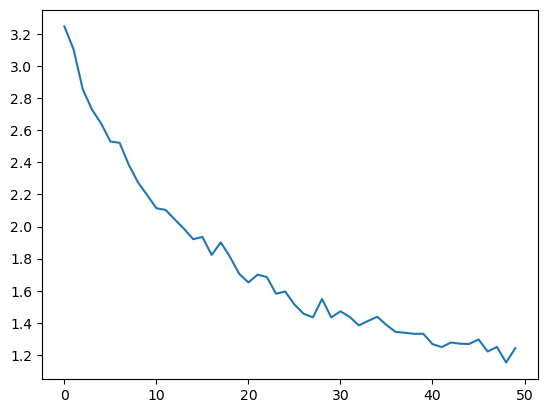

In [58]:
def show_plot(points) :
  plt.figure()
  fig, ax = plt.subplots()
  # This locator puts ticks at regular intervals
  loc = ticker.MultipleLocator(base=.2)
  ax.yaxis.set_major_locator(loc)
  plt.title("Training loss")
  plt.
  plt.plot(points)

show_plot(plot_losses)

## Evaluate the model

input_length 7
encoder_outputs torch.Size([7, 1, 500])
encoder_hidden torch.Size([2, 1, 500])
tensor([[1.7951e-14, 1.0000e+00, 1.0146e-31, 4.0595e-40, 2.8193e-41, 1.4209e-37,
         1.0848e-28],
        [1.3389e-15, 1.0000e+00, 1.6874e-32, 1.0707e-40, 0.0000e+00, 0.0000e+00,
         2.8026e-45],
        [0.0000e+00, 4.6527e-39, 1.0000e+00, 3.7014e-29, 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [8.0662e-01, 1.9338e-01, 8.8620e-37, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.0000e+00, 4.1422e-15, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.0000e+00, 1.5076e-13, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00]])
> je suis dans la meme galere
= i m in the same boat
< i m in the same <EOS>



/tmp/ipykernel_23086/3262303860.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(attn_energies).unsqueeze(0).unsqueeze(0)
/tmp/ipykernel_23086/1620053795.py:35: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(self.out(torch.cat((rnn_output, context), dim=1)))


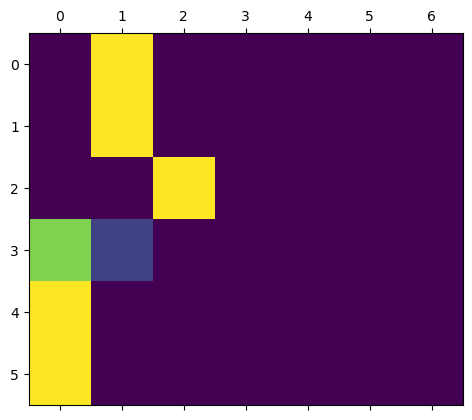

In [108]:
def evaluate(sentence, max_length=MAX_LENGTH) :
  input_variable = variable_from_sentence(input_lang, sentence)
  input_length = input_variable.size()[0]
  print("input_length", input_length)

  # Run through encoder
  encoder_hidden = encoder.init_hidden()
  encoder_outputs, encoder_hidden = encoder(input_variable, encoder_hidden)
  print("encoder_outputs", encoder_outputs.shape)
  print("encoder_hidden", encoder_hidden.shape)

  # Create starting vectors for decoder
  decoder_input = Variable(torch.LongTensor([[SOS_TOKEN]])) # SOS
  decoder_context = Variable(torch.zeros(1, decoder.hidden_size))
  if USE_CUDA :
    decoder_input = decoder_input.cuda()
    decoder_context = decoder_context.cuda()
  
  decoder_hidden = encoder_hidden
  decoded_words = []
  decoder_attentions = torch.zeros(max_length, max_length)
  
  # Run through decoder
  for di in range(max_length) :
    decoder_output, decoder_context, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_context, decoder_hidden, encoder_outputs)
    decoder_attentions[di, :decoder_attention.size(2)] += decoder_attention.squeeze(0).squeeze(0).cpu().data

    # Choose top word from output
    topv, topi = decoder_output.data.topk(1)
    ni = topi[0][0]
    if ni.item() == EOS_TOKEN :
      decoded_words.append("<EOS>")
      break
    else :
      decoded_words.append(output_lang.index2word[ni.item()])
    
    # Next input is chosen word
    decoder_input = Variable(torch.LongTensor([[ni.item()]]))
    if USE_CUDA :
      decoder_input = decoder_input.cuda()
  print(decoder_attentions[:di+1, :len(encoder_outputs)])
  return decoded_words, decoder_attentions[:di+1, :len(encoder_outputs)]

def evaluate_randomly() :
  pair = random.choice(pairs)

  output_words, decoder_attns = evaluate(pair[0])
  output_sentence = ' '.join(output_words)

  print('>', pair[0])
  print('=', pair[1])
  print('<', output_sentence)
  print('')
  return pair, output_words, decoder_attns

pair, output_words, decoder_attns = evaluate_randomly()
plt.matshow(decoder_attns.numpy())